# Import libraries

In [85]:
import math
import torch
import numpy as np
import tensorly as tsl
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from scipy.sparse import csr_matrix, linalg
from scipy.sparse.linalg import spsolve
from tensorly.decomposition import tensor_ring

In [86]:
device = torch.device("cuda")# if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

SR=0.2

False


# NTRC Algorithm

In [87]:
def NTRC_algorithm(ystar, y, Xn, T, Tk, K, lambda_, alpha_k, tol=1e-6, max_iter=500):
    # Initialization
    mu = 1e-4
    nu = 1.1
    mu_max = 1e10
    Mk = []
    Qk = []
    for k in range(K):
        Mk.append(torch.zeros_like(Tk[k]))
        Qk.append(torch.zeros_like(Tk[k]))
    t = 1
    T_prev = T.clone()
    convergence = []
    relative_error = []
    PSNR = []
    min_re = float('inf')
    threshold_re = 100
    D = int(np.prod(T.size()))

    # Main loop
    while True:
        # Update Mk
        for k in range(K):
            A = Tk[k] - (1/mu)*Qk[k]
            U, S, V = torch.svd(A)
            tau = lambda_*alpha_k/mu
            Vt = V.t()
            S_threshold = torch.diag(torch.max(S-tau, torch.zeros_like(S)))
            Mk[k] = U @ S_threshold @ Vt

        # Update Tk
        T = update_T(y, Xn, T, K, mu, Qk, Mk)

        # Update Qk
        for k in range(K):
            Qk[k] = Qk[k] + mu * (Mk[k] - Tk[k])

        # Update mu
        mu = min(mu_max, nu * mu)

        # Check convergence
        t_conv = (torch.norm(T - T_prev, 'fro')**2) / (torch.norm(T_prev, 'fro')**2)
        t_re   = (torch.norm(T - ystar, 'fro')**2) / (torch.norm(ystar, 'fro')**2)
        t_psnr = 10 * torch.log10(D* (torch.max(torch.abs(T))**2) / (torch.norm(T - ystar, p='fro') ** 2))

        print(f'{t:03d}: convergence: {t_conv:.10f},\t RE: {t_re:.10f},\t PSNR: {t_psnr:.10f}')
        convergence.append(t_conv)
        relative_error.append(t_re)
        PSNR.append(t_psnr)
        if t_re <= tol:
            break
        if t_re <= min_re:
            Tmin = T.clone()
            min_re = t_re
        elif t_re >= threshold_re:
            break

        # Update iteration
        t += 1
        if t > max_iter:
            break

        # Keep track of previous T
        T_prev = T.clone()

    return Tmin, convergence, relative_error, PSNR

def update_T(y, Xn, T, K, mu, Qk, Mk):
    D = int(np.prod(T.size()))
    #Vectorizing tensors 
    vecX = torch.flatten(Xn)
    vecQM = torch.flatten(Qk[0] + Mk[0])
    for i in range(1,K):
        vecQM += torch.flatten(Qk[i] + Mk[i])
        
    # Create sparse matrix representation of the large I(DxD) matrix
    bigID = torch.ones(D) * mu * K + vecX.t()@vecX # Diagonal elements
    row = torch.arange(D)
    col = torch.arange(D)
    sparse_matrix = csr_matrix((bigID.numpy(), (row.numpy(), col.numpy())), shape=(D, D))
    ft_plus1 = torch.tensor(spsolve(sparse_matrix, (mu*vecQM - vecX@torch.flatten(y))))

    # sparse_matrix_inv = linalg.inv(sparse_matrix)
    # ft_plus1 = torch.tensor(sparse_matrix_inv) @ (mu*vecQM - vecX@torch.flatten(y))
    # ft_plus1 = torch.pinverse((vecX.t() @ vecX) + mu*K*torch.eye(D)) @ (mu*vecQM - vecX@torch.flatten(y))

    T_plus1 = torch.sign(ft_plus1) * torch.min(torch.abs(ft_plus1), torch.tensor(mu))
    T_plus1 = T_plus1.view_as(T)
    return T_plus1

# Image Processing

## Import image

In [88]:
# Load the image
image = Image.open("picture/trainImg.jpg")  # Replace "example_image.jpg" with the path to your image file

# Define transformations to resize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# Apply transformations
orginal_tensor3d = transform(image)

## Sampling & random noise image

In [89]:
def add_noise_uniformly(image_tensor, noise_std, sampling_ratio=0.4):
    """
    Add Gaussian noise to a percentage of pixels sampled uniformly at random from the image tensor.

    Args:
        image_tensor (torch.Tensor): Input image tensor.
        noise_std (float): Standard deviation of the Gaussian noise.
        sampling_ratio (float): Percentage of pixels to sample uniformly at random.

    Returns:
        torch.Tensor: Image tensor with noise added to selected pixels.
    """
    # Calculate the number of pixels to sample
    num_pixels = int(sampling_ratio * image_tensor.numel() / image_tensor.size(0))  # Number of pixels per channel

    # Create a mask to select pixels randomly
    mask = torch.zeros_like(image_tensor)
    mask.view(-1)[torch.randperm(image_tensor.numel())[:num_pixels]] = 1

    # Add Gaussian noise to the selected pixels
    noise = torch.randn_like(image_tensor) * noise_std
    noisy_tensor = image_tensor + mask * noise

    return noisy_tensor

import torch

def mask_tensor(tensor, mask_ratio=0.4):
    """
    Masks out a random portion of the values in the input tensor.

    Args:
        tensor (torch.Tensor): Input tensor.
        mask_ratio (float): Ratio of values to mask out.

    Returns:
        torch.Tensor: Tensor with masked values.
    """
    num_values = tensor.numel()  # Total number of values in the tensor
    num_values_to_mask = int(mask_ratio * num_values)  # Number of values to mask out

    # Create a mask tensor with zeros and ones (1 indicates values to keep)
    mask = torch.zeros_like(tensor)
    mask.view(-1)[torch.randperm(num_values)[:num_values_to_mask]] = 1

    # Apply the mask to the input tensor
    masked_tensor = tensor * mask

    return masked_tensor


# Calculate Frobenius norm of the image tensor
frobenius_norm = torch.norm(orginal_tensor3d, p='fro')
sqrt_D = math.sqrt(512*512*3)
s = ((0.25 * frobenius_norm) / sqrt_D).item()

noisy_tensor3d = add_noise_uniformly(orginal_tensor3d, noise_std=s, sampling_ratio=0.5)
noisy_tensor3d = mask_tensor(noisy_tensor3d, mask_ratio=1-SR)
noisy_tensor5d = noisy_tensor3d.view(3, 16, 16, 32, 32)
print(noisy_tensor5d.size())

torch.Size([3, 16, 16, 32, 32])


# Tensor Ring Decomposition

torch.Size([1, 3, 2])
torch.Size([2, 16, 3])
torch.Size([3, 16, 4])
torch.Size([4, 32, 5])
torch.Size([5, 32, 1])
Reconstruction error: 25869.09765625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Tensor Decomposed Image')

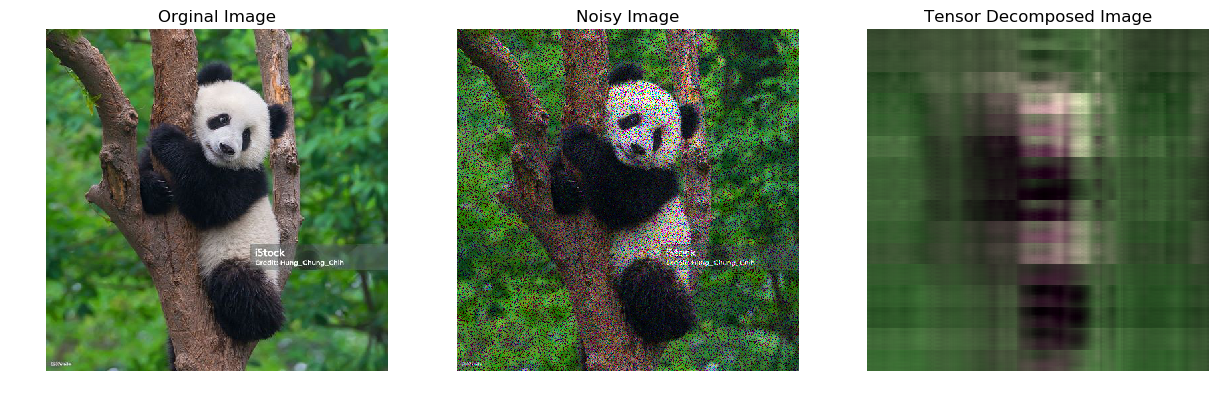

In [90]:
# Perform tensor ring decomposition
rank = [1, 2, 3, 4, 5, 1]  # Define the rank for each dimension
factors = tensor_ring(input_tensor=tsl.tensor(noisy_tensor5d), rank=rank)
T_approximate = tsl.tensor(factors)
for i,ts in enumerate(T_approximate):
    T_approximate[i] = torch.tensor(ts)
    print(T_approximate[i].size())

# Reconstruct the tensor from the decomposition
reconstructed_tensor5d = torch.einsum('abc, cde, efg, ghi, ijk -> bdfhj', T_approximate[0], T_approximate[1], T_approximate[2], T_approximate[3], T_approximate[4])

# Print the reconstruction error (Frobenius norm of the difference between the original and reconstructed tensor)
reconstruction_error = torch.norm(noisy_tensor5d - reconstructed_tensor5d.view(noisy_tensor5d.shape), p='fro')**2
print("Reconstruction error:", reconstruction_error.item())
reconstructed_tensor3d = reconstructed_tensor5d.view(3, 512, 512)

# Display the image
# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot the first image
axes[0].imshow(orginal_tensor3d.permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('Orginal Image')
# Plot the second image
axes[1].imshow(noisy_tensor3d.permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('Noisy Image')
# Plot the second image
axes[2].imshow(reconstructed_tensor3d.permute(1, 2, 0))
axes[2].axis('off')
axes[2].set_title('Tensor Decomposed Image')

In [91]:
torch.norm(noisy_tensor3d - orginal_tensor3d, 'fro')**2 / torch.norm(orginal_tensor3d, 'fro')**2

tensor(0.2080)

# Training Preparation

In [92]:
K = 5
alpha_k = 1/K

## Create circular unfold tensors $T_{(k,s)}$

In [93]:
def circular_unfold(T, K_, s):
    Tks = []
    for k in range(K_):
        #Caculate the shape of permute
        l = k + s - 1 - K_*(k+s > K_)
        permuteShape = list(range(l+1, K_)) + list(range(l+1))

        # Calculate the shape of resize
        d1k=1
        d2k=1
        k_id = permuteShape.index(k)
        for i in range(k_id): #in range [l+1, k-1]
            d1k *= T.shape[permuteShape[i]]
        for j in range(k_id, K_): #in range [k, l]
            d2k *= T.shape[permuteShape[j]]

        unfold = T.permute(permuteShape).reshape(d1k, d2k)
        Tks.append(unfold)
        print(f'k:{k}, l:{l}, permuteShape: {permuteShape}, unfoldShape: {unfold.shape}')
    return Tks


circular_unfold_tensors = circular_unfold(T=noisy_tensor5d, K_=5, s=3)

k:0, l:2, permuteShape: [3, 4, 0, 1, 2], unfoldShape: torch.Size([1024, 768])
k:1, l:3, permuteShape: [4, 0, 1, 2, 3], unfoldShape: torch.Size([96, 8192])
k:2, l:4, permuteShape: [0, 1, 2, 3, 4], unfoldShape: torch.Size([48, 16384])
k:3, l:0, permuteShape: [1, 2, 3, 4, 0], unfoldShape: torch.Size([256, 3072])
k:4, l:1, permuteShape: [2, 3, 4, 0, 1], unfoldShape: torch.Size([512, 1536])


## Create uniform sampling tensor $\mathcal{X}_n$

In [94]:
def tensor_uniform_sampling(dims):
    # Create a grid of indices using torch.meshgrid
    grids = torch.meshgrid([torch.arange(dim) for dim in dims])
    
    # Reshape the grids to form a tensor of indices
    indices = torch.stack(grids, dim=-1)
    
    # Reshape dims to match the shape of indices
    dims_tensor = torch.tensor(dims, dtype=torch.float32).reshape(1, 1, -1)
    
    # Generate the tensor using broadcasting and tensor operations
    tensor = torch.prod(torch.sin(indices * (2 * math.pi / dims_tensor)), dim=-1)
    
    return tensor

uniform_sampled_tensors = tensor_uniform_sampling(noisy_tensor5d.shape)
print(uniform_sampled_tensors)

tensor([[[[[ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
           ...,
           [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],

          [[ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
           ...,
           [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],

          [[ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
           [ 0.

# Train NTRC

In [95]:
def calculate_lamda(a, T_star=noisy_tensor5d, Tk=circular_unfold_tensors, SR=SR):
    
    D = np.prod(T_star.size())
    sigma = 0.25 * T_star.norm() / (D ** 0.5)
    N = SR * D

    # Retreive shape of Tk
    Tk_shape = []
    for cut in Tk:
        Tk_shape.append((cut.shape[0], cut.shape[1]))
    #Find k* = argmin(d1k ^ d2k)
    k_star = np.argmin(np.min(np.array(Tk_shape), axis=1))
    #Find d~ = d1k + d2k
    d_approx = np.sum(Tk_shape[k_star])
    #Find d^ = d1k ^ d2k
    d_hat = min(Tk_shape[k_star])
    # print(f'k*: {k_star}, d~ = {d_approx}, d^ = {d_hat}')

    lambda_0 = sigma * np.sqrt(N * np.log(d_approx)/d_hat)
    lambda_ = a * lambda_0
    return lambda_.item()

## a = 10^-2

In [96]:
# lambda_ = calculate_lamda(1e-3, noisy_tensor5d)
T1, convergence1, relative_error1, PSNR1 = NTRC_algorithm(ystar = orginal_tensor3d.view_as(noisy_tensor5d),
                                          y = noisy_tensor5d, 
                                          Xn= uniform_sampled_tensors,
                                          T = reconstructed_tensor5d,
                                          Tk= circular_unfold_tensors, 
                                          K=K, lambda_=calculate_lamda(1e-3), alpha_k=alpha_k)

001: convergence: 1.0006537437,	 RE: 1.0004363060,	 PSNR: -71.3829040527
002: convergence: 0.0099956123,	 RE: 1.0004976988,	 PSNR: -70.5553131104
003: convergence: 0.0099919029,	 RE: 1.0005476475,	 PSNR: -69.7276763916
004: convergence: 0.0099892858,	 RE: 1.0006064177,	 PSNR: -68.9000778198
005: convergence: 0.0100097992,	 RE: 1.0006419420,	 PSNR: -68.0723800659
006: convergence: 0.0100121219,	 RE: 1.0006917715,	 PSNR: -67.2447433472
007: convergence: 0.0100122588,	 RE: 1.0007674694,	 PSNR: -66.4172210693
008: convergence: 0.0100022992,	 RE: 1.0008420944,	 PSNR: -65.5896911621
009: convergence: 0.0100051118,	 RE: 1.0009937286,	 PSNR: -64.7624893188
010: convergence: 0.0099984361,	 RE: 1.0010893345,	 PSNR: -63.9350547791
011: convergence: 0.0100127067,	 RE: 1.0012549162,	 PSNR: -63.1079177856
012: convergence: 0.0100116432,	 RE: 1.0013700724,	 PSNR: -62.2805633545
013: convergence: 0.0100025451,	 RE: 1.0014336109,	 PSNR: -61.4529838562
014: convergence: 0.0099782106,	 RE: 1.0016382933,	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


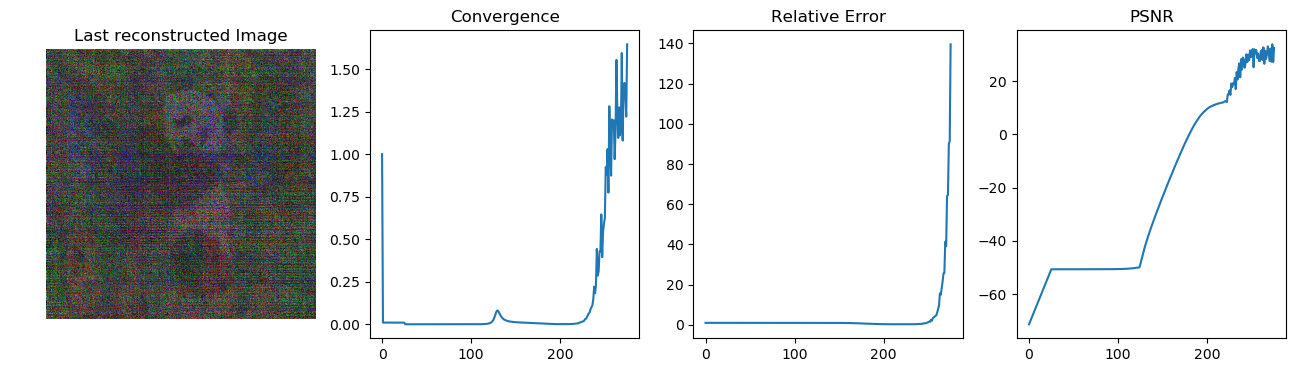

In [97]:
import matplotlib.pyplot as plt

# Display the image
# Plot the images
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
# Plot the first image
axes[0].imshow((T1.view(3, 512, 512)).permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('Last reconstructed Image')

# Plot the remaining plots
axes[1].plot(convergence1)
axes[1].set_title('Convergence')

axes[2].plot(relative_error1)
axes[2].set_title('Relative Error')

axes[3].plot(PSNR1)
axes[3].set_title('PSNR')

plt.show()